# dataFilling — Missing-Data Imputation Workflow


This notebook performs structured data preparation and gap-filling using Monte Carlo Simulation

In [5]:
#Imports
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import os
from scipy.stats import gaussian_kde
from scipy.stats import norm
from  datetime import datetime, timedelta
from scipy.stats import truncnorm
import re
%matplotlib inline

In [6]:
 # Csv and Excel file filter
file_paths = [file for file in os.listdir() if '.xlsx' in file or '.csv' in file ] 
file_paths  

['Aeropuertomadroa - deneme (1).xlsx',
 'CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS_2023-10-02 00_00_00_-_2023-11-03 23_59_59.csv',
 'FLORIDARICARDO - deneme.xlsx',
 'MARTINEZARAGON - deneme.xlsx',
 'PRAZAGARCIA - deneme.xlsx',
 'PSOALFONSO - deneme.xlsx',
 'VIA NORTE-URZAIZ a PRAZA DA ESTACION_2023-10-02 00_00_00_-_2023-11-03 23_59_59.csv']

In [7]:
#Excel and Csv files seperation
csvs = [file for file in file_paths if file.endswith('.csv')]
xlsxs = [file for file in file_paths if file.endswith('.xlsx')]

In [8]:
def file_to_df(file) : 
    # If the path ends with "csv", read as comma-separated values.
    # Note: this is a simple suffix check (case-sensitive); it does not handle gzip, case variants, or custom delimiters.
    if file.endswith("csv") :
        return pd.read_csv(file)

    # If the path ends with "xlsx", read as an Excel workbook (first sheet by default).
    # Note: legacy ".xls" is not handled here by design.
    elif file.endswith("xlsx"):
        return pd.read_excel(file)

    else : 
        # For any other extension, return a concise message indicating lack of support.
        # Caution: `file.split(".")[1]` will fail if there is no dot in the filename.
        return "type " + file.split(".")[1] + " is not supported"

In [ ]:
#Conversion of files to the pandas dataframe
csv_dfs = [file_to_df(csv) for csv in csvs]
xlsx_dfs = [file_to_df(xlsx) for xlsx in xlsxs]

In [ ]:
#Demonstration of a csv dataframe
csv_dfs[0]

,Vector,Description,Date,Year,Month,Day,Hour,Minutes,Seconds,detected_devices,...,losstime hours,losstime minutes,losstime seconds,typical_speed,typical_traveltime,typical_losstime,Congestion,wheather_icon,wheather_temp,weather_desc
0,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-10-02 00:00:00,2023,10,2,0,0,0,3,...,0,0,7.63,27.86,23.91,7.26,NaN,undefinedn,NaN,NaN
1,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-10-02 00:03:00,2023,10,2,0,3,0,6,...,0,0,7.63,27.73,24.02,7.37,NaN,NaN,NaN,NaN
2,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-10-02 00:06:00,2023,10,2,0,6,0,2,...,0,0,13.20,27.77,23.98,7.33,NaN,NaN,NaN,NaN
3,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-10-02 00:09:00,2023,10,2,0,9,0,12,...,0,0,16.90,28.09,23.71,7.06,NaN,NaN,NaN,NaN
4,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-10-02 00:12:00,2023,10,2,0,12,0,8,...,0,0,9.21,28.58,23.30,6.65,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14477,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-11-02 12:21:00,2023,11,2,12,21,0,0,...,0,0,21.85,23.99,27.76,11.11,NaN,NaN,NaN,NaN
14478,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-11-02 12:24:00,2023,11,2,12,24,0,0,...,0,0,25.24,24.11,27.62,10.97,NaN,NaN,NaN,NaN
14479,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-11-02 12:27:00,2023,11,2,12,27,0,0,...,0,0,25.85,24.19,27.54,10.89,NaN,NaN,NaN,NaN
14480,115,CASTRELOS-ANTONIO PALACIOS a CASTRELOS-BALAIDOS,2023-11-02 12:30:00,2023,11,2,12,30,0,0,...,0,0,32.79,24.41,27.29,10.64,NaN,NaN,NaN,NaN


In [ ]:
#Demonstration of a excel dataframe
xlsx_dfs[0]

,Hacim (tş/6dk),Hız,Hacim (tş/sa)
0,47,84.95,940
1,23,84.95,460
2,19,84.95,380
3,62,84.40,1240
4,18,84.70,360
...,...,...,...
13015,223,75.71,4460
13016,113,76.30,2260
13017,120,75.25,2400
13018,168,78.09,3360


In [ ]:
# Selection of the first loaded DataFrame from each collection.
xlsx_df_1 = xlsx_dfs[0]
csv_df_1  = csv_dfs[0]

In [ ]:
#Demonstration of traffic volumes in an excel dataframe
xlsx_df_1["Hacim (tş/6dk)"]

0         47
1         23
2         19
3         62
4         18
        ... 
13015    223
13016    113
13017    120
13018    168
13019    141
Name: Hacim (tş/6dk), Length: 13020, dtype: int64

In [ ]:
#Demonstration of value counts of traffic volumes in an excel dataframe
xlsx_df_1["Hacim (tş/6dk)"].value_counts().sort_index()

Hacim (tş/6dk)
0      34
1      28
2      38
3      56
4      68
       ..
434     1
435     1
448     1
450     1
455     1
Name: count, Length: 401, dtype: int64

In [26]:
#Demonstration of traffic volumes in a csv dataframe
csv_df_1["detected_devices"]

0         3
1         6
2         2
3        12
4         8
         ..
14477     0
14478     0
14479     0
14480     0
14481     0
Name: detected_devices, Length: 14482, dtype: int64

In [27]:
#Demonstration of value counts of traffic volumes in a csv dataframe
csv_df_1["detected_devices"].value_counts().sort_index()

detected_devices
0     231
1     264
2     409
3     514
4     466
     ... 
79      2
80      1
81      2
82      2
86      1
Name: count, Length: 83, dtype: int64

In [ ]:
def plot_data_distrubution(df, column_name, create_figure=True, return_ax=False):

    # Optionally create a fresh figure to avoid drawing over prior plots
    if create_figure:
        plt.figure(figsize=(20, 10))
    
    # Draw normalized histogram (PDF estimate) with fixed bin count
    # Returns (counts, bin_edges, patches); assigned to `ax` by convention here.
    ax = plt.hist(df[column_name], density= True , color="gray", bins=30)

    # Basic plot annotations for readability
    plt.title(f'Histogram of {column_name}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')  # Semantically this is density due to density=True
    plt.show()

    # Optionally expose the tuple returned by plt.hist to the caller
    if return_ax:
        return ax
    

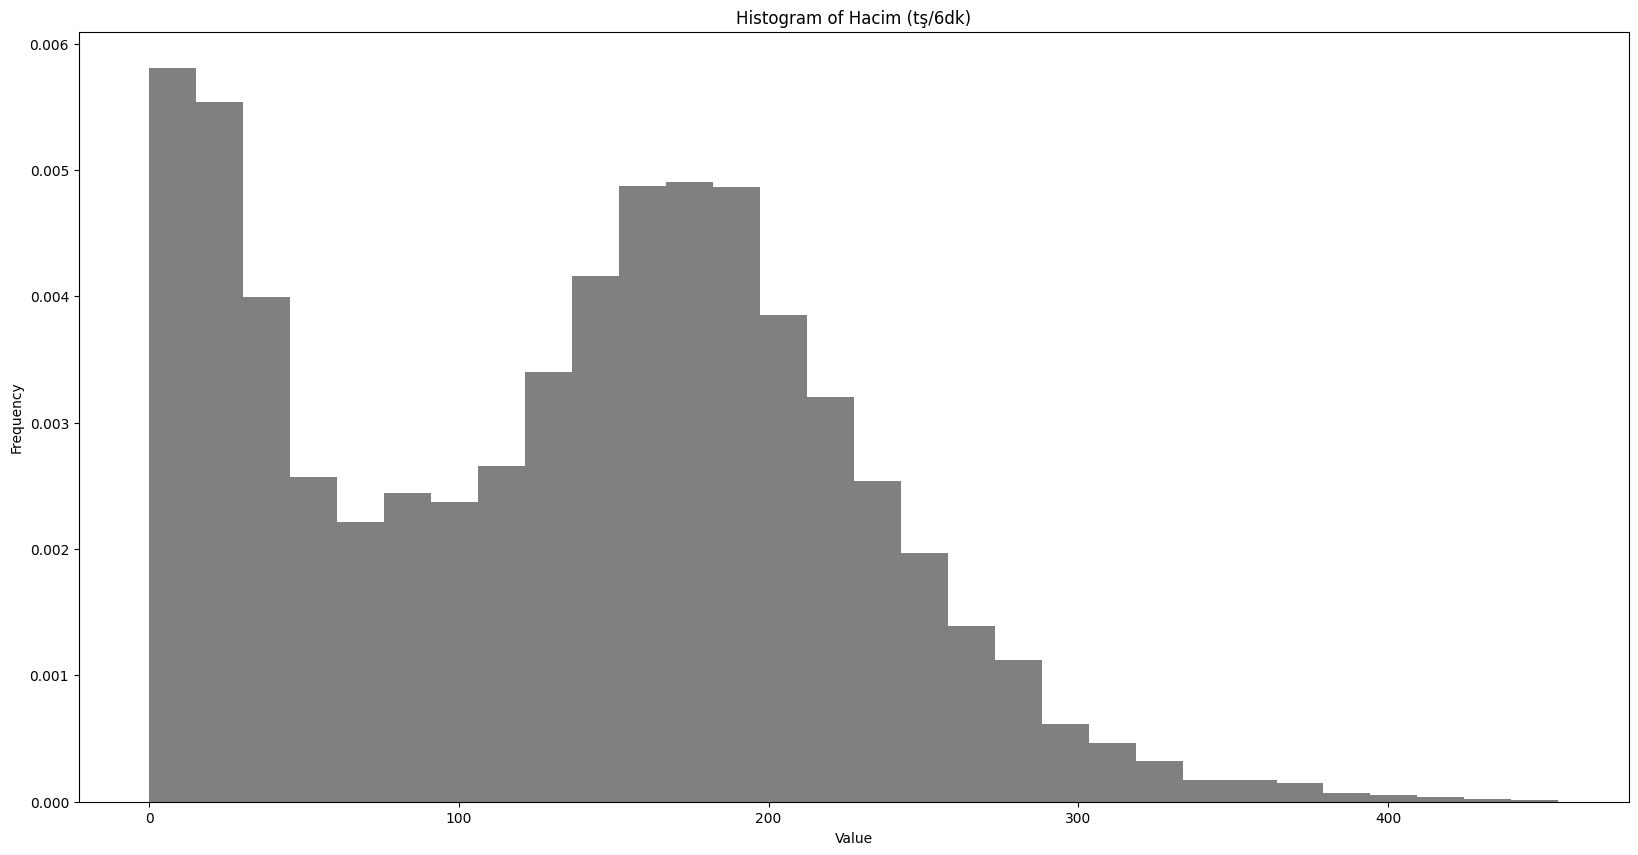

In [ ]:
#Demonstration of traffic volume distribution of an excel dataframe
plot_data_distrubution(xlsx_df_1, "Hacim (tş/6dk)")

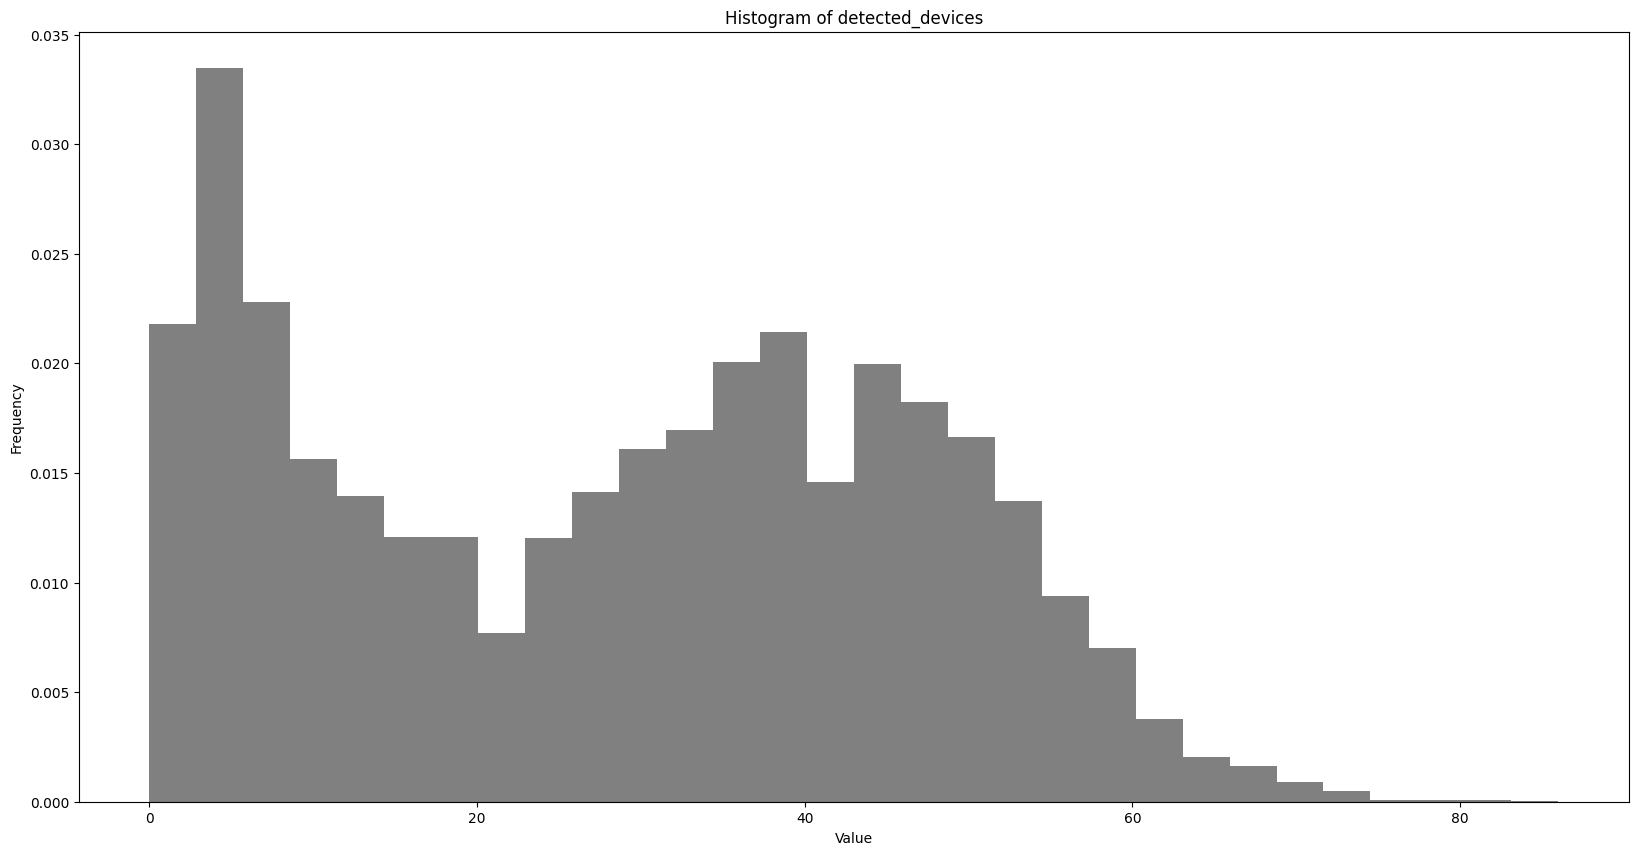

In [ ]:
#Demonstration of traffic volume distribution of an csv dataframe
plot_data_distrubution(csv_df_1, "detected_devices")

In [ ]:
# Monte Carlo sampler over a discrete `sample` via truncated normal weights on [0, 1].
# Idea:
#   Draw Z ~ TruncNormal(mean=0.5, std=0.1, bounds=[0,1]), partition [0,1] into
#   equal sub-intervals (one per element of `sample`), and select the item whose
#   interval contains Z. Repeating this induces a *center-biased* discrete
#   distribution over indices (middle elements more probable).
#
# Parameters
# ----------
# sample : sequence
#     Indexable container (e.g., list/ndarray) of values to sample from.
#     Length must be >= 1.
# num_iterations : int
#     Number of Monte Carlo draws; each draw picks one element from `sample`.
#
# Returns
# -------
# int
#     The integer-cast mean of the drawn values (i.e., floor toward zero).
#     Note this discards fractional information; keep as float if you need a
#     proper estimator of E[value].
#

def monte_carlo_simulation(sample, num_iterations):
    results = []  # collected draws mapped to actual values from `sample`

    for _ in range(num_iterations):
        # Define truncation bounds in the unit interval.
        lower, upper = 0, 1

        # Truncated normal parameters centered in the middle of [0,1] with modest spread.
        mean, std = 0.5, 0.1

        # Standardize bounds for scipy.stats.truncnorm parameterization.
        a, b = (lower - mean) / std, (upper - mean) / std

        # Draw a single variate Z ~ TruncNormal(a,b) mapped back via loc/scale to [0,1].
        result = truncnorm(a, b, loc=mean, scale=std).rvs()

        # Partition [0,1] into equal bins; one bin per element in `sample`.
        interval_count = 1 / len(sample)

        # Compute the bin index using floor division; yields a float representing floor(Z / Δ).
        index = result // interval_count

        # Map bin index to the corresponding element of `sample`.
        # Note: int(index) floors; potential IndexError if index == len(sample).
        number = sample[int(index)]

        # Store the drawn value for later aggregation.
        results.append(number)

    # Return the integer-cast mean of drawn values (information-losing on purpose here).
    return int(np.mean(results))


In [ ]:
# Purpose:
#   Detect gaps in a time-indexed sequence (3-minute cadence assumed) and
#   recursively insert imputed rows into `df_copy` using Monte Carlo sampling
#   over hour-matched historical values from `df_main`.
#
# Parameters
# ----------
# df_main : pd.DataFrame
#     Reference dataset providing historical samples used for imputation.
# df_copy : pd.DataFrame
#     Working dataset to scan and augment with missing rows (same schema).
# trace : int
#     Cursor pointing to the "current" row in `df_copy` used for next-timestamp comparison.
# index : str
#     Column name holding the timestamp strings (format "YYYY-MM-DD HH:MM:SS").
# filled_column_name : str
#     Column to be imputed when a 3-minute gap is detected.
# num_iterations : int
#     Number of draws used by `monte_carlo_simulation` when filling a missing value.
#
# Behavior / Assumptions
# ----------------------
# • Time strings are parsed by a custom splitter (regex on "-|:| ") and passed to datetime(...).
#   Any deviation from "YYYY-MM-DD HH:MM:SS" will raise.
# • The expected cadence is exactly 3 minutes; gaps are detected by comparing
#   (current_time + 3min) against the next row at position `trace + 1`.
# • When a gap is found, a new row is built for (current_time + 3min) and the
#   target column is imputed by Monte Carlo sampling conditioned on matching hour-of-day.
# • The function recurses on the tail slice starting at the insertion point to
#   handle multi-step gaps.
#
# Notes / Caveats
# ---------------
# • `np.array(df_copy[index])[-1]` gets the last timestamp; used to stop the scan.
# • `df_copy.index += (trace - col_index)` shifts the index labels (not row order);
#   this is cosmetic and can affect downstream joins/alignments if relied upon.
# • `monte_carlo_simulation(sample, ...)` returns an int(mean(sampled_values)),
#   which is a coarse estimator; prints are left for traceability.
# • Potential edge cases: empty `sample` for a given hour; out-of-range `trace + 1`;
#   recursing until base case relies on eventually closing all 3-minute gaps.

def detect_and_fill_missing_vals(df_main, df_copy, trace, index, filled_column_name, num_iterations):
    # Last timestamp in the working DataFrame; used as a sentinel to stop scanning.
    last_element = np.array(df_copy[index])[-1]

    # Local cursor counting how many rows we have inspected/inserted in this frame.
    col_index = 0

    # Helper: parse a "YYYY-MM-DD HH:MM:SS" string into a datetime object.
    def str_to_dt(string):
        dt_obj = datetime(*tuple(int(x) for x in (re.split("-|:| ", (string)))))
        return dt_obj
    
    # Iterate over timestamp strings in the working column.
    for date in df_copy[index]:
        # Stop if we reached the last observed timestamp.
        if date == last_element :
            break

        # If the next expected timestamp (current + 3 minutes) matches the next row at trace+1,
        # advance both cursors and continue scanning.
        if (datetime(*tuple(int(x) for x in (re.split("-|:| ", (date))))) + timedelta(minutes=3))\
                   .strftime("%Y-%m-%d %H:%M:%S") == df_copy[index][trace + 1] :
                     
            col_index += 1   # move local cursor
            trace += 1       # move global/outer cursor reference
            continue
        
        else :
            # Gap detected: compute the missing timestamp and prepare an imputation.
            dt_obj = str_to_dt(date)

            # Build a conditioning sample: values from the target column for rows in df_main
            # whose hour-of-day matches the current timestamp's hour.
            sample = [column for obj, column in zip(df_main[index], df_main[filled_column_name]) if str_to_dt(obj).hour == dt_obj.hour]

            # Diagnostic prints to observe the candidate pool and a trial draw.
            print(sample)
            print(monte_carlo_simulation(sample, num_iterations=1000))
            
            # Inform about the detected missing row position.
            print(f"ROW {trace + 1} DOESNT EXISTS")

            # Prepare the new row: timestamp is current + 3 minutes, target value via Monte Carlo.
            new_values = {index : (dt_obj + timedelta(minutes=3))\
                       .strftime("%Y-%m-%d %H:%M:%S"),
                       filled_column_name : str(int(monte_carlo_simulation(sample, num_iterations)))}

            # Create a Series for insertion; `name` sets the temporary index label pre-reset.
            new_row = pd.Series(data=new_values, name=col_index + 1)
            print(new_values)

            # Split `df_copy` around the insertion point and insert the new row.
            df_copy1 = df_copy.iloc[:col_index + 1]
            df_copy2 = df_copy.iloc[col_index + 1:]
            df_copy = pd.concat([df_copy1, pd.DataFrame(new_row).T, df_copy2]).reset_index(drop=True)

            # Shift index labels so they reflect the external `trace` offset (cosmetic).
            df_copy.index += (trace - col_index) 
            
            # Recurse on the tail starting at the insertion position to handle consecutive gaps.
            splitted_df = pd.DataFrame(df_copy[col_index:])
            df_copy = pd.concat([df_copy[:col_index],\
                                 detect_and_fill_missing_vals(df_main, splitted_df,\
                                        trace, index, filled_column_name, num_iterations)])
            
            # After handling this gap (and its downstream effects), exit the current loop frame.
            break

    # Return the augmented DataFrame with any detected gaps filled.
    return df_copy


In [ ]:
#Spesification of the number of iterations of the monte carlo simulation 
num_iterations = 1000

In [ ]:
#Running the simulation for each csv files
for csv in csv_dfs:
    df_filled = detect_and_fill_missing_vals(csv.copy(), 
                                             csv.copy(), 
                                             0, 
                                             "Date", 
                                             "detected_devices", 
                                             num_iterations)
    csv.copy().to_excel(F"input_csv_{index}.xlsx", index=False)
    df_filled.to_excel(F"output_csv_{index}.xlsx", index=False)